In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy.stats.mstats import winsorize

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  

In [3]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [4]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

# Dropeo columnas que no sirven (despues de feature_importance inicial)

In [5]:
# Elimino las variantes de has_secondary_use
train_values_base = train_values.iloc[:,:28]
# Dropeo legal_ownership_status. No sirve para el algoritmo. ¿Reemplazar?
train_values_base = train_values_base.drop(labels='legal_ownership_status',axis=1)

In [6]:
train_values_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

## Analisis columna por columna

## Geo Level Id

Analizar para los geo_level_id que más daño sufrieron cuales son las características más importantes y se puede hacer un feature booleano.  
Podemos hacer mean encoding y poner el porcentaje de esa ciudad.  
Por ejemplo para todos los que pertenezcan al geo_level_id_1 "17", tendrán una nueva columna con geo_level_id_1_dmg "80.15" porque en esa zona hubo ese porcentaje de daño.  
Problemas: 
- leak del daño 
- ¿Es necesario más granularidad? (también para otros geo_level_id?)   
- Los id son útiles porque si fue una zona donde hubo gran cantidad de daño entonces un nuevo valor verá en que id pertenece y de ahí determinar que es lo más probable. 

# Columnas mal distribuidas (age,area_percentage,height_percentage)

### area_percentage

<AxesSubplot:>

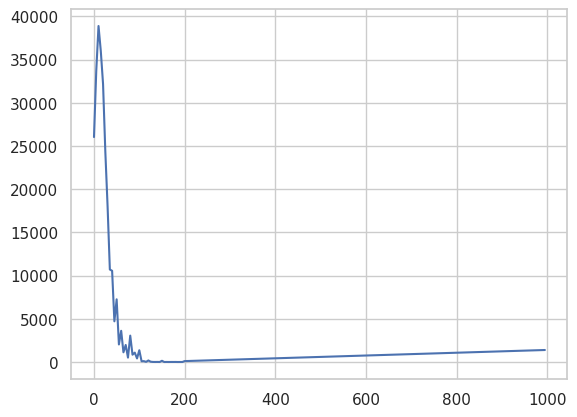

In [7]:
train_values_base['age'].value_counts().sort_index().plot()

<AxesSubplot:>

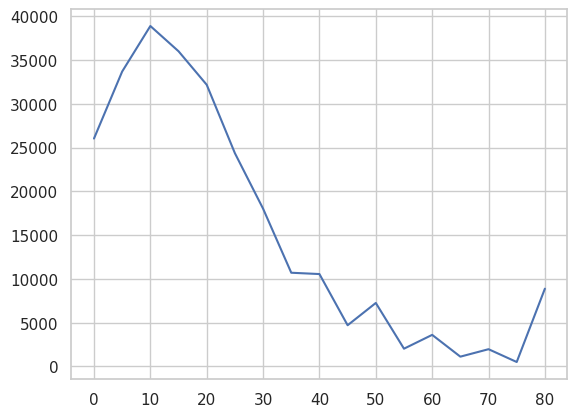

In [8]:
#El valor 60 es un buen valor para que sea el máximo. Más alla de 60 se considera antigua.
age_winsorized = winsorize(train_values_base['age'],(0,0.03))
columna_age_w = pd.Series(np.ma.filled(age_winsorized))
columna_age_w.value_counts().sort_index().plot()

<AxesSubplot:>

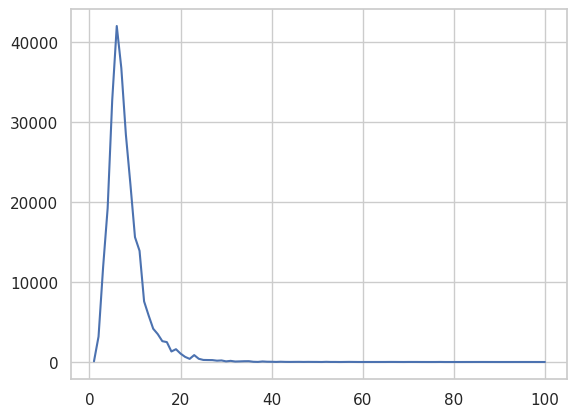

In [9]:
train_values_base['area_percentage'].value_counts().sort_index().plot()

<AxesSubplot:>

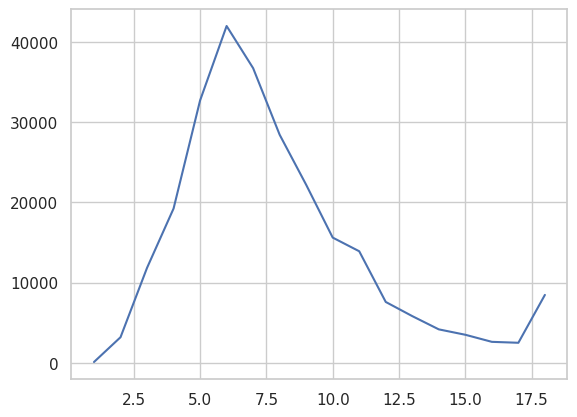

In [10]:
# A la vista, quiero que el máximo sea 12 porque a partir de ese valor empieza a decrecer más lento. 
# También puede ser 20 pero lo sigue dejando poco distruido. Elijo 16 (el promedio) que se alcanza on percentile 0.05 
area_percentage_winsorized = winsorize(train_values_base['area_percentage'],(0,0.03))
columna_area_percentage_w = pd.Series(np.ma.filled(area_percentage_winsorized))
columna_area_percentage_w.value_counts().sort_index().plot()

<AxesSubplot:>

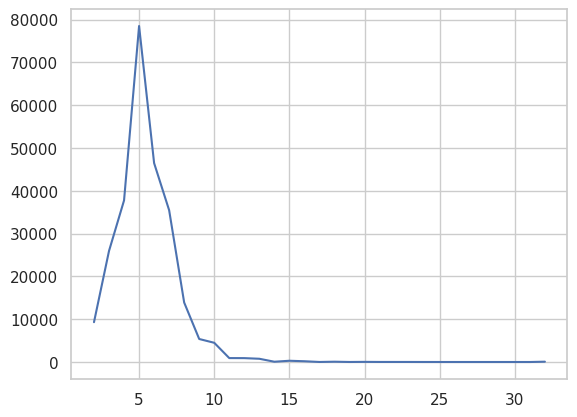

In [11]:
train_values_base['height_percentage'].value_counts().sort_index().plot()

<AxesSubplot:>

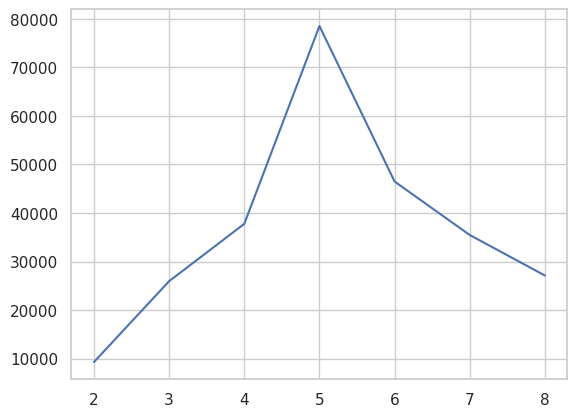

In [12]:
#Percentile 5 más alto.
height_percentage_winsorized = winsorize(train_values_base['height_percentage'],(0,0.06))
columna_height_percentage_w = pd.Series(np.ma.filled(height_percentage_winsorized))
columna_height_percentage_w.value_counts().sort_index().plot()

Probamos el algoritmo con este data set base